In [1]:
import numpy as np
from cv2 import cv2
from tqdm import tqdm
from scipy.spatial.distance import cosine
import matplotlib.pyplot as plt
from matplotlib import rcParams

rcParams['figure.figsize'] = (12, 12)

In [6]:
def prepare_img(img, roi=None, downscale_factor=4, kernel_size=3):
    """
    Prepare image for keypoint matching
    :param img: Image in BGR format
    :param roi: Region of interest to crop image to in format x0, y0, x1, y1
    :param downscale_factor: Factor to downscale image
    :param kernel_size: Size of kernel for blurring
    :return: Grayed, downscaled and blurred image
    """

    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = img[roi[1]:roi[3], roi[0]:roi[2]] if roi is not None else img
    img = cv2.resize(
        img, (int(img.shape[1] // downscale_factor), int(img.shape[0] // downscale_factor)))
    img = cv2.medianBlur(img, kernel_size)

    return img


def get_good_matches(ref_descs, descs, ratio_thresh=0.15):
    # matcher = cv2.BFMatcher(cv2.NORM_HAMMING)
    matcher = cv2.FlannBasedMatcher(
        {'algorithm': 0, 'trees': 5}, {'checks': 50})
    matches = matcher.knnMatch(ref_descs, descs, k=2)

    good_matches = []
    for match in matches:
        if len(match) > 1:
            if match[0].distance < ratio_thresh * match[1].distance:
                good_matches.append(match)

    return good_matches


def plot_matches(img1, img2, pts1, pts2, matches):
    ref_kps = [cv2.KeyPoint(*pt, 50) for pt in pts1]
    kps = [cv2.KeyPoint(*pt, 50) for pt in pts2]

    vis = cv2.drawMatchesKnn(img1, ref_kps, img2, kps, matches, None, flags=2)
    plt.imshow(vis)
    plt.show()


def get_matching_points(img1, img2, roi1=None, roi2=None, downscale_factor=4, kernel_size=3, ratio_thresh=0.15, plot=False):
    """
    Using points and descriptors retrieved by a keypoint matcher (here: AKAZE) generate bounding boxes on a new image
    For robustness and accuracy, for each labeled object only nearby keypoints are considered and outliers are removed
    :param img1: Reference image
    :param img2: New image to compare
    :param roi1: Region of interest to crop image to in format x0, y0, x1, y1
    :param roi2: Region of interest to crop image to in format x0, y0, x1, y1
    :param downscale_factor: Scaling factor to resize image for better feature extraction
    :param kernel_size: Size of kernel for blurring
    :param ratio_thresh: Threshold to filter out bad matches [0, 1] (the higher the more matches will be considered)
    :param plot: Whether to plot the matched pairs of keypoints
    :return: Average shift in keypoints
    """

    # detector = cv2.AKAZE_create()
    detector = cv2.xfeatures2d.SIFT_create()

    # Get keypoints and descriptor for compared image
    kpss, descss = [], []
    for img, roi in zip([img1, img2], [roi1, roi2]):
        img_prepd = prepare_img(
            img, roi=roi, downscale_factor=downscale_factor, kernel_size=kernel_size)
        kps, descs = detector.detectAndCompute(img_prepd, None)

        kpss.append(kps)
        descss.append(descs)

    # Get actual points for original image by transforming back the keypoints
    pss = [np.array([kp.pt for kp in kps]) * downscale_factor + (roi[:2]
                                                                 if roi is not None else (0, 0)) for kps, roi in zip(kpss, [roi1, roi2])]

    # Filter keypoints and descriptors of current image based on matches with reference image
    tries = 0
    good_matches = get_good_matches(*descss, ratio_thresh=ratio_thresh)
    # Succesively increaser ratio_thresh to get more matches
    while len(good_matches) == 0 and tries < 3:
        good_matches = get_good_matches(
            *descss, ratio_thresh=min((tries + 2) * ratio_thresh, 0.99))
        tries += 1

    matched_pts1 = pss[0][[match[0].queryIdx for match in good_matches]]
    matched_pts2 = pss[1][[match[0].trainIdx for match in good_matches]]

    if plot:
        plot_matches(img1, img2, *pss, good_matches)

    return pss[0], pss[1], good_matches, matched_pts1, matched_pts2


def filter_matches(matched_pts1, matched_pts2):
    dists = [cosine(matched_pt1, matched_pt2) for matched_pt1,
             matched_pt2 in zip(matched_pts1, matched_pts2)]
    q75, q25 = np.percentile(dists, [75, 25])
    iqr = q75 - q25
    mask = (dists > q25 - 1.5 * iqr) & (dists < q75 + 1.5 * iqr)

    return matched_pts1[mask], matched_pts2[mask]


In [8]:
def stitch_images(img1, img2, H):
    '''warp img2 to img1 with homograph H'''
    h1, w1 = img1.shape[:2]
    h2, w2 = img2.shape[:2]
    pts1 = np.float32([[0, 0], [0, h1], [w1, h1], [w1, 0]]).reshape(-1, 1, 2)
    pts2 = np.float32([[0, 0], [0, h2], [w2, h2], [w2, 0]]).reshape(-1, 1, 2)
    pts2_ = cv2.perspectiveTransform(pts2, H)
    pts = np.concatenate((pts1, pts2_), axis=0)
    [xmin, ymin] = np.int32(pts.min(axis=0).ravel() - 0.5)
    [xmax, ymax] = np.int32(pts.max(axis=0).ravel() + 0.5)
    t = [-xmin, -ymin]
    Ht = np.array([[1, 0, t[0]], [0, 1, t[1]], [0, 0, 1]])  # translate

    result = cv2.warpPerspective(img2, Ht.dot(H), (xmax-xmin, ymax-ymin))
    result[t[1]:h1+t[1], t[0]:w1+t[0]] = img1

    return result, t


def create_panorama(img_paths, rois, downscale_factor=4, kernel_size=3, ratio_thresh=0.15, ransac_thresh=4, filter=False):
    stitched_img = cv2.imread(img_paths[0])

    gen = zip(*[[lst[i:i + 2] for i in range(len(lst) - 1)]
              for lst in [img_paths, rois]])

    for img_path_pair, roi_pair in tqdm(gen, total=len(img_paths) - 1):
        img_pair = [cv2.imread(path) for path in img_path_pair]
        pts1, pts2, good_matches, matched_pts1, matched_pts2 = get_matching_points(*img_pair, *roi_pair, downscale_factor=downscale_factor,
                                                                                   kernel_size=kernel_size, ratio_thresh=ratio_thresh)
        if filter:                                                                                   
            matched_pts1, matched_pts2 = filter_matches(matched_pts1, matched_pts2)
        
        homography, _ = cv2.findHomography(matched_pts_right, matched_pts_left, cv2.RANSAC, ransacReprojThreshold=ransac_thresh)
        stitched_img, _ = stitch_images(stitched_img, img_pair[1], homography)

    return stitched_img

In [9]:
def create_panorama2(img_paths, rois, downscale_factor=4, kernel_size=3, ratio_thresh=0.15, ransac_thresh=4, filter=False):
    """
    Image paths must be left to right
    """
    img_paths = img_paths[::-1] # reverse list so that images come from right to left

    stitched_img, last_translation = None, None
    gen = zip(*[[lst[i:i + 2] for i in range(len(lst) - 1)] for lst in [img_paths, rois]])

    for img_path_pair, roi_pair in tqdm(gen, total=len(img_paths) - 1):
        img_right, img_left = [cv2.imread(path) for path in img_path_pair] # TODO check direction

        _, _, _, matched_pts_left, matched_pts_right = get_matching_points(img_left, img_right, downscale_factor=downscale_factor, kernel_size=kernel_size, ratio_thresh=ratio_thresh)
        if filter:
            matched_pts_left, matched_pts_right = filter_matches(matched_pts_left, matched_pts_right)

        homography_left_right, _ = cv2.findHomography(matched_pts_right + ([0, 0] if last_translation is None else last_translation), matched_pts_left, cv2.RANSAC, ransacReprojThreshold=ransac_thresh)
        
        stitched_img, last_translation = stitch_images(img_left, img_right if stitched_img is None else stitched_img, homography_left_right)

    return stitched_img    

In [2]:
RATIO_THRESH = 0.7
DOWNSCALE_FACTOR = 4
KERNEL_SIZE = 3
RANSAC_THRESH = 4

In [4]:
# img_paths = ["../assets/test_images/1Hill.JPG", "../assets/test_images/2Hill.JPG", "../assets/test_images/3Hill.JPG"]
# img_paths = [f"../assets/drone_images/DSC{f'{i:05d}'}.JPG" for i in range(798, 801)]

# TODO make it work for each direction of next image, i.e. if the direction changes from left->right to right->left
# Up->down can only be handled by new warping function
img_paths = [f"../assets/drone_images_orig/DSC{f'{i:05d}'}.JPG" for i in range(798, 800)]

img_left, img_right = [cv2.imread(path) for path in img_paths]
rois = [None for _ in img_paths]

In [12]:
_, _, _, matched_pts_left, matched_pts_right = get_matching_points(img_left, img_right, downscale_factor=DOWNSCALE_FACTOR, kernel_size=KERNEL_SIZE, ratio_thresh=RATIO_THRESH)

homography_left_right, mask = cv2.findHomography(matched_pts_right, matched_pts_left, cv2.RANSAC, ransacReprojThreshold=RANSAC_THRESH)

In [16]:
img_left.shape

(3064, 5456, 3)

In [17]:
np.unique(mask)

array([0, 1], dtype=uint8)

In [40]:
img_paths = [f"../assets/drone_images_orig/DSC{f'{i:05d}'}.JPG" for i in range(798, 810)]
rois = [None for _ in img_paths]

In [41]:
all([os.path.exists(path) for path in img_paths])

True

100%|██████████| 11/11 [00:15<00:00,  1.42s/it]


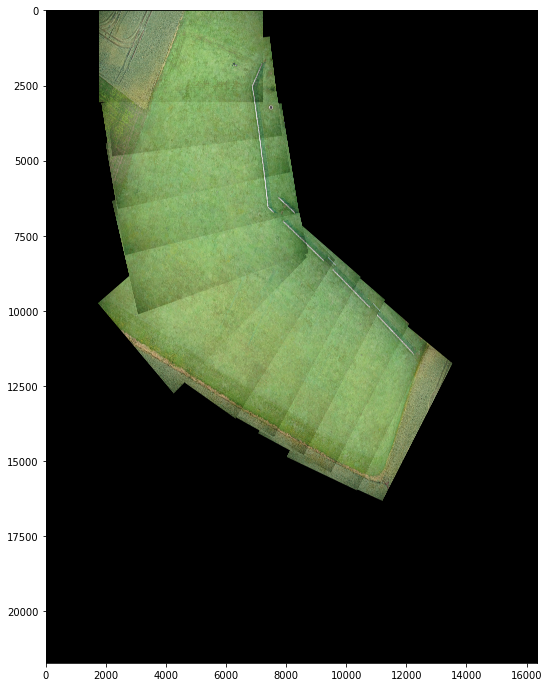

In [42]:
stitched_all = create_panorama2(img_paths, rois, downscale_factor=DOWNSCALE_FACTOR, kernel_size=KERNEL_SIZE, ratio_thresh=RATIO_THRESH, ransac_thresh=RANSAC_THRESH)
plt.imshow(cv2.cvtColor(stitched_all, cv2.COLOR_BGR2RGB))

In [23]:
_, _, _, matched_pts_left, matched_pts_center = get_matching_points(img_left, img_center, kernel_size=KERNEL_SIZE, downscale_factor=DOWNSCALE_FACTOR, ratio_thresh=RATIO_THRESH)

# findHomograhpy returns a mask which can be used to macke black pixels transparent
# homography needs to be right to left as right image is warped to left image
homography_center_left, _ = cv2.findHomography(matched_pts_center, matched_pts_left, cv2.RANSAC, ransacReprojThreshold=RANSAC_THRESH)

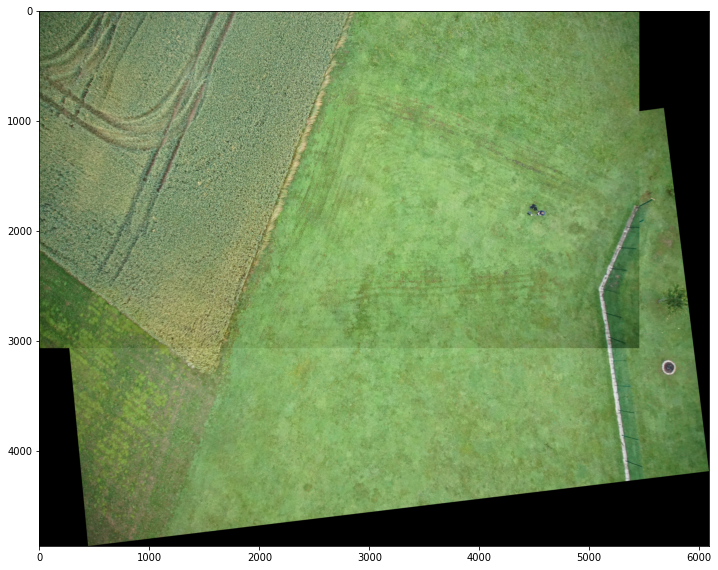

In [24]:
stitched_left_center, _ = stitch_images(img_left, img_center, homography_center_left)
plt.imshow(cv2.cvtColor(stitched_left_center, cv2.COLOR_BGR2RGB))


In [8]:
stitched_all = create_panorama(img_paths, rois, downscale_factor=DOWNSCALE_FACTOR, kernel_size=KERNEL_SIZE, ratio_thresh=RATIO_THRESH, ransac_thresh=RANSAC_THRESH)
plt.imshow(cv2.cvtColor(stitched_all, cv2.COLOR_BGR2RGB))

  0%|          | 0/2 [00:00<?, ?it/s]


NameError: name 'matched_pts_right' is not defined

[0, 36]


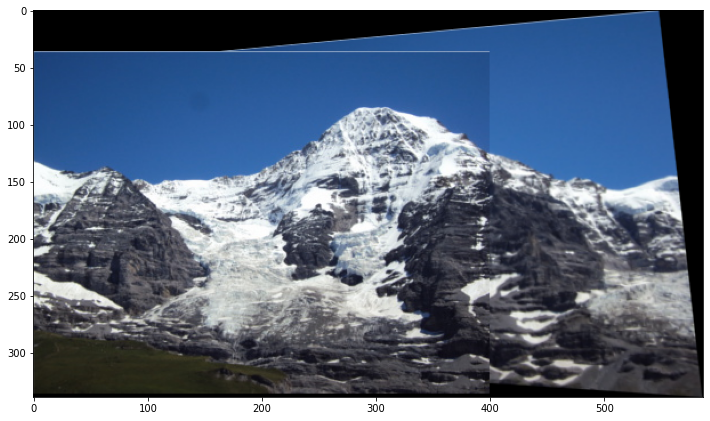

In [9]:
_, _, _, matched_pts_center, matched_pts_right = get_matching_points(img_center, img_right, kernel_size=KERNEL_SIZE, downscale_factor=DOWNSCALE_FACTOR, ratio_thresh=RATIO_THRESH)
homography_center_right, _ = cv2.findHomography(matched_pts_right, matched_pts_center, cv2.RANSAC, ransacReprojThreshold=RANSAC_THRESH)
stitched_center_right, t = stitch_images(img_center, img_right, homography_center_right)
plt.imshow(cv2.cvtColor(stitched_center_right, cv2.COLOR_BGR2RGB))
print(t)

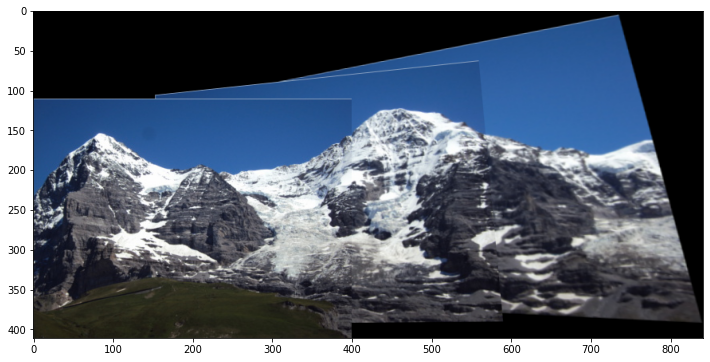

In [11]:
_, _, _, matched_pts_left, matched_pts_center_right = get_matching_points(img_left, stitched_center_right, kernel_size=KERNEL_SIZE, downscale_factor=DOWNSCALE_FACTOR, ratio_thresh=RATIO_THRESH)
homography_left_center_right, _ = cv2.findHomography(matched_pts_center_right, matched_pts_left, cv2.RANSAC, ransacReprojThreshold=RANSAC_THRESH)
stitched_left_center_right, _ = stitch_images(img_left, stitched_center_right, homography_left_center_right)
plt.imshow(cv2.cvtColor(stitched_left_center_right, cv2.COLOR_BGR2RGB))

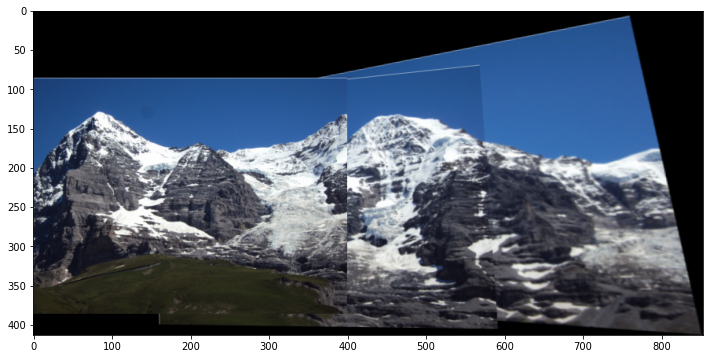

In [10]:
_, _, _, matched_pts_left, matched_pts_center = get_matching_points(img_left, img_center, kernel_size=KERNEL_SIZE, downscale_factor=DOWNSCALE_FACTOR, ratio_thresh=RATIO_THRESH)
homography_left_center, _ = cv2.findHomography(matched_pts_center, matched_pts_left, cv2.RANSAC, ransacReprojThreshold=RANSAC_THRESH)
stitched_left_center_right, _ = stitch_images(img_left, stitched_center_right, homography_left_center)
plt.imshow(cv2.cvtColor(stitched_left_center_right, cv2.COLOR_BGR2RGB))

[[ 22.91749763 224.46942139]
 [ 34.03238678 209.87779236]
 [ 50.12999725 181.56594849]
 [ 59.12210083 192.20437622]
 [ 66.06478882 171.89328003]
 [ 67.29463959 202.95375061]
 [ 78.26838684 217.83067322]
 [ 95.24236298 175.95347595]
 [109.90682983 125.37333679]
 [108.62462616 145.67562866]
 [108.41952515 211.92718506]
 [ 95.24236298 175.95347595]
 [128.16955566 152.55963135]
 [137.68226624 261.30975342]
 [149.20751953 141.68017578]
 [167.50994873 222.06047058]
 [173.71754456 241.54832458]
 [190.87965393 123.89852905]
 [190.87965393 123.89852905]
 [189.31951904 257.63088989]
 [198.82046509 155.66680908]
 [206.96743774 108.60418701]
 [202.50186157 223.42419434]
 [213.41395569 129.3626709 ]
 [211.84629822 238.88397217]
 [220.60388184 152.3956604 ]]
[[ 22.91749763 260.46942139]
 [ 34.03238678 245.87779236]
 [ 50.12999725 217.56594849]
 [ 59.12210083 228.20437622]
 [ 66.06478882 207.89328003]
 [ 67.29463959 238.95375061]
 [ 78.26838684 253.83067322]
 [ 95.24236298 211.95347595]
 [109.9068298

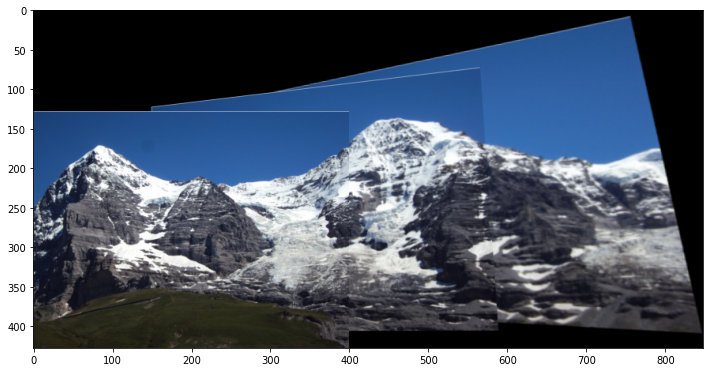

In [15]:
# Add translation to matched points of stitched image
_, _, _, matched_pts_left, matched_pts_center = get_matching_points(img_left, img_center, kernel_size=KERNEL_SIZE, downscale_factor=DOWNSCALE_FACTOR, ratio_thresh=RATIO_THRESH)
homography_left_center, _ = cv2.findHomography(matched_pts_center + t, matched_pts_left, cv2.RANSAC, ransacReprojThreshold=RANSAC_THRESH)
stitched_left_center_right, _ = stitch_images(img_left, stitched_center_right, homography_left_center)
plt.imshow(cv2.cvtColor(stitched_left_center_right, cv2.COLOR_BGR2RGB))